## POS tagging using modified Viterbi

### Data Preparation

In [48]:
#Importing libraries
import nltk


In [49]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [50]:
# first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [51]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [52]:
# split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

print("Train Set :",len(train_set))
print("Test Set :",len(test_set))
print("Train Set Data : \n ",train_set[:10])

Train Set : 3718
Test Set : 196
Train Set Data : 
  [[('Whereas', 'ADP'), ('conventional', 'ADJ'), ('securities', 'NOUN'), ('financings', 'NOUN'), ('are', 'VERB'), ('structured', 'VERB'), ('*-3', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('sold', 'VERB'), ('*-1', 'X'), ('quickly', 'ADV'), (',', '.'), ('Wall', 'NOUN'), ('Street', 'NOUN'), ("'s", 'PRT'), ('new', 'ADJ'), ('penchant', 'NOUN'), ('for', 'ADP'), ('leveraged', 'ADJ'), ('buy-outs', 'NOUN'), ('and', 'CONJ'), ('junk', 'NOUN'), ('bonds', 'NOUN'), ('is', 'VERB'), ('resulting', 'VERB'), ('in', 'ADP'), ('long-term', 'ADJ'), ('lending', 'VERB'), ('commitments', 'NOUN'), ('that', 'DET'), ('*T*-2', 'X'), ('stretch', 'VERB'), ('out', 'PRT'), ('for', 'ADP'), ('months', 'NOUN'), ('or', 'CONJ'), ('years', 'NOUN'), ('.', '.')], [('He', 'PRON'), ('also', 'ADV'), ('said', 'VERB'), ('that', 'ADP'), ('after', 'ADP'), ('the', 'DET'), ('charges', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('*-1', 'X'), ('``', '.'), ('assuming', 'VERB'), ('no', 'DET'), ('dra

In [53]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95604

In [54]:
# train data tagged tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Whereas',
 'conventional',
 'securities',
 'financings',
 'are',
 'structured',
 '*-3',
 'to',
 'be',
 'sold']

In [55]:
# train data vocabulary
V = set(tokens)
print(len(V))

12082


In [56]:
# Train data tags- set
T = set([pair[1] for pair in train_tagged_words])
print("Number of tags:", len(T))
print(T)

Number of tags: 12
{'DET', 'X', 'ADV', 'ADJ', 'ADP', 'PRON', 'NUM', 'VERB', 'NOUN', 'PRT', '.', 'CONJ'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. 
To every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) = count(w, t) / count(t). 
P(t) -> the probability of tag t.


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [57]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [58]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)


### Transition Probabilities

In [59]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)



In [60]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [61]:
tags_matrix

array([[5.19135594e-03, 4.49112654e-02, 1.27972960e-02, 2.04273820e-01,
        9.17541981e-03, 3.50114703e-03, 2.16105282e-02, 3.95991802e-02,
        6.40347719e-01, 2.41458416e-04, 1.78679228e-02, 4.82916832e-04],
       [5.50531484e-02, 7.45676681e-02, 2.52260827e-02, 1.74520072e-02,
        1.45962238e-01, 5.52118048e-02, 2.85578286e-03, 2.04029828e-01,
        6.25099167e-02, 1.84039339e-01, 1.63096935e-01, 9.99524072e-03],
       [6.81515932e-02, 2.29388289e-02, 7.91223422e-02, 1.30651593e-01,
        1.18351065e-01, 1.49601065e-02, 3.25797871e-02, 3.44747335e-01,
        3.25797871e-02, 1.42952129e-02, 1.34640962e-01, 6.98138308e-03],
       [4.95131221e-03, 2.11255979e-02, 4.29113721e-03, 6.66776672e-02,
        7.70754218e-02, 6.60174934e-04, 2.11255979e-02, 1.20481923e-02,
        6.97804928e-01, 1.12229744e-02, 6.60174936e-02, 1.69995055e-02],
       [3.24257940e-01, 3.48067470e-02, 1.36664528e-02, 1.05808243e-01,
        1.63356829e-02, 6.86525702e-02, 6.31005764e-02, 8.00

In [62]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [63]:
tags_df

,DET,X,ADV,ADJ,ADP,PRON,NUM,VERB,NOUN,PRT,.,CONJ
DET,0.005191,0.044911,0.012797,0.204274,0.009175,0.003501,0.021611,0.039599,0.640348,0.000241,0.017868,0.000483
X,0.055053,0.074568,0.025226,0.017452,0.145962,0.055212,0.002856,0.204030,0.062510,0.184039,0.163097,0.009995
ADV,0.068152,0.022939,0.079122,0.130652,0.118351,0.014960,0.032580,0.344747,0.032580,0.014295,0.134641,0.006981
ADJ,0.004951,0.021126,0.004291,0.066678,0.077075,0.000660,0.021126,0.012048,0.697805,0.011223,0.066017,0.017000
ADP,0.324258,0.034807,0.013666,0.105808,0.016336,0.068653,0.063101,0.008008,0.322763,0.001495,0.040252,0.000854
PRON,0.009626,0.093955,0.034655,0.073161,0.021948,0.007701,0.007316,0.484790,0.209087,0.012322,0.040046,0.005391
NUM,0.003850,0.211134,0.002961,0.032573,0.034350,0.001481,0.184483,0.018656,0.353568,0.027539,0.115191,0.014214
VERB,0.133954,0.218859,0.081568,0.065037,0.091579,0.035390,0.022584,0.169422,0.109895,0.031354,0.035002,0.005355
NOUN,0.012995,0.029201,0.016973,0.012119,0.176997,0.004782,0.009417,0.147649,0.263506,0.043656,0.240108,0.042597
PRT,0.101146,0.013093,0.009493,0.084452,0.020295,0.018985,0.057283,0.400655,0.248118,0.001637,0.043208,0.001637


In [64]:
tags_df.loc['.', :]

DET     0.173780
X       0.027136
ADV     0.052835
ADJ     0.043760
ADP     0.091293
PRON    0.065954
NUM     0.081229
VERB    0.088148
NOUN    0.222212
PRT     0.002426
.       0.093360
CONJ    0.057777
Name: ., dtype: float32

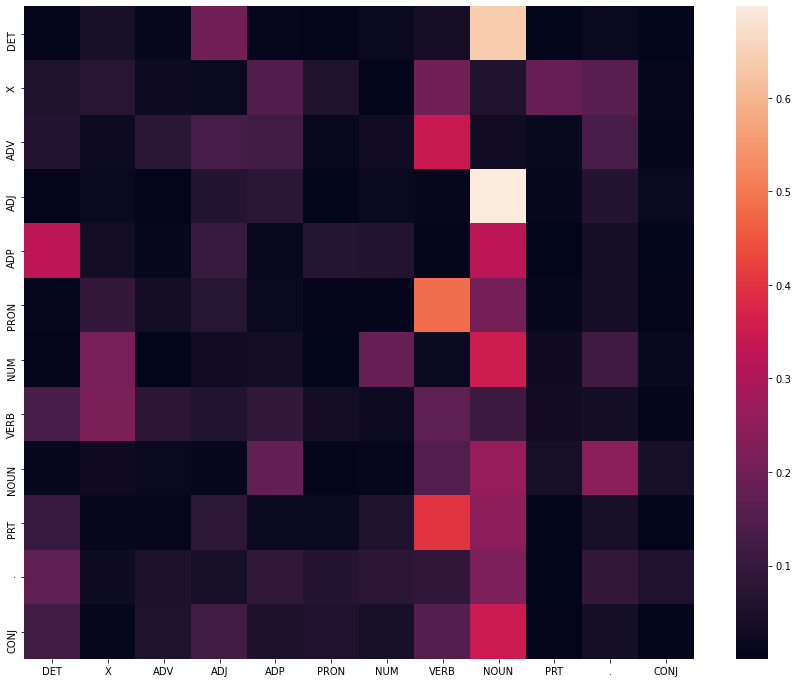

In [65]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(15, 12))
sns.heatmap(tags_df)
plt.show()


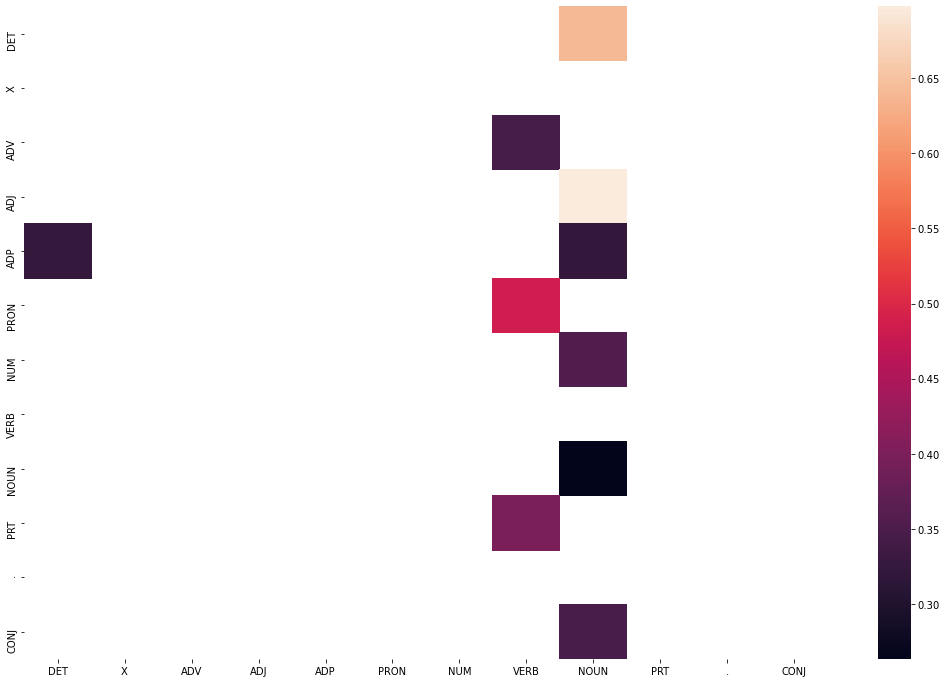

In [66]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### INFERENCE:

- From above heatmap, we can observe that most of the transition probabilities are between Noun and other parts of speech such as Adjective and Determinant.
- Transition Probability between Verb and pronoun is also high

### Build the vanilla Viterbi based POS tagger

In [67]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [68]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Lorillard', 'NOUN'),
  ('Inc.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('unit', 'NOUN'),
  ('of', 'ADP'),
  ('New', 'ADJ'),
  ('York-based', 'ADJ'),
  ('Loews', 'NOUN'),
  ('Corp.', 'NOUN'),
  ('that', 'DET'),
  ('*T*-2', 'X'),
  ('makes', 'VERB'),
  ('Kent', 'NOUN'),
  ('cigarettes', 'NOUN'),
  (',', '.'),
  ('stopped', 'VERB'),
  ('using', 'VERB'),
  ('crocidolite', 'NOUN'),
  ('in', 'ADP'),
  ('its', 'PRON'),
  ('Micronite', 'NOUN'),
  ('cigarette', 'NOUN'),
  ('filters', 'NOUN'),
  ('in', 'ADP'),
  ('1956', 'NUM'),
  ('.', '.')],
 [('If', 'ADP'),
  ('they', 'PRON'),
  ('test-drive', 'VERB'),
  ('a', 'DET'),
  ('Buick', 'NOUN'),
  (',', '.'),
  ('they', 'PRON'),
  ('get', 'VERB'),
  ('an', 'DET'),
  ('American', 'NOUN'),
  ('Express', 'NOUN'),
  ('calculator', 'NOUN'),
  ('.', '.')],
 [('*', 'X'),
  ('Filling', 'VERB'),
  ('out', 'PRT'),
  ('detailed', 'ADJ'),
  ('forms', 'NOUN'),
  ('about', 'ADP'),
  ('these', 'DET'),
  ('individuals', 'NOUN'),
  ('would', 'VERB'),
  ('tip

In [69]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [70]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  30.46361231803894
[('Lorillard', 'NOUN'), ('Inc.', 'NOUN'), (',', '.'), ('the', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('York-based', 'NOUN'), ('Loews', 'DET'), ('Corp.', 'NOUN'), ('that', 'ADP'), ('*T*-2', 'X'), ('makes', 'VERB'), ('Kent', 'NOUN'), ('cigarettes', 'NOUN'), (',', '.'), ('stopped', 'VERB'), ('using', 'VERB'), ('crocidolite', 'NOUN'), ('in', 'ADP'), ('its', 'PRON'), ('Micronite', 'DET'), ('cigarette', 'NOUN'), ('filters', 'NOUN'), ('in', 'ADP'), ('1956', 'NUM'), ('.', '.'), ('If', 'ADP'), ('they', 'PRON'), ('test-drive', 'DET'), ('a', 'DET'), ('Buick', 'NOUN'), (',', '.'), ('they', 'PRON'), ('get', 'VERB'), ('an', 'DET'), ('American', 'ADJ'), ('Express', 'NOUN'), ('calculator', 'DET'), ('.', '.'), ('*', 'X'), ('Filling', 'DET'), ('out', 'ADP'), ('detailed', 'ADJ'), ('forms', 'NOUN'), ('about', 'ADP'), ('these', 'DET'), ('individuals', 'NOUN'), ('would', 'VERB'), ('tip', 'DET'), ('the', 'DET'), ('IRS', 'NOUN'), ('off', 'PRT'), ('a

In [71]:
# Calculate accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.8715596330275229

In [72]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]] #incorrect tags

In [73]:
incorrect_tagged_cases

[[('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('York-based', 'ADJ'), (('Loews', 'DET'), ('Loews', 'NOUN'))],
 [('Corp.', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('its', 'PRON'), (('Micronite', 'DET'), ('Micronite', 'NOUN'))],
 [('they', 'PRON'), (('test-drive', 'DET'), ('test-drive', 'VERB'))],
 [('an', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('Express', 'NOUN'), (('calculator', 'DET'), ('calculator', 'NOUN'))],
 [('*', 'X'), (('Filling', 'DET'), ('Filling', 'VERB'))],
 [('Filling', 'VERB'), (('out', 'ADP'), ('out', 'PRT'))],
 [('would', 'VERB'), (('tip', 'DET'), ('tip', 'VERB'))],
 [('worth', 'ADJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('broken', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('a', 'DET'), (('Sanford', 'DET'), ('Sanford', 'NOUN'))]]

In [74]:
# Unknown words 
# building the train vocabulary to a set
training_vocabulary_set = set(tokens)
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 7


Unknown Words : ['Filling', 'Sanford', 'Micronite', 'Loews', 'calculator', 'test-drive', 'tip']


### Solve the problem of unknown words

#### Method 1: Lexion Unigram with Rule based tagging

In this method we use rules that are set by us using regular expression pattern and we match that with a tag.
This set pattern rule is passed to unigram tagger, which assigns the most commonly assigned tag to a word.
If we combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

In [75]:
# pattern created and mapped to tag

pattern = [
        (r'^[aA-zZ].*[0-9]+','NOUN'), #alpha numeric
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*ing$', 'VERB'),              # gerund, VERB
        (r'.*ed$', 'VERB'),               # past tense
        (r'.*es$', 'VERB'),               # 3rd singular present
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),# cardinal numbers
        (r'.*ing$', 'VERB'),
        (r'.*ly$', 'ADV'), 
        (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
        (r'.*able$', 'ADJ'), 
        (r'.*ful$', 'ADJ'),
        (r'.*ous$', 'ADJ'),
        (r'.*ty$', 'ADJ'),
        (r'.*', 'NOUN') # default value as NOUN

]


#creating a function with unigram tagger and rule based

def rule_based_tagging(word, pattern):
    unigram_tagger = nltk.UnigramTagger(train_set) #unigram lexion tagger
    unigram_tagger.evaluate(test_set)
    regexp_tagger = nltk.RegexpTagger(pattern)
    # rule based tagger
    rule_based_tagger = nltk.RegexpTagger(pattern)
    # lexicon backed up by the rule-based tagger
    lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
    lexicon_tagger.evaluate(test_set)
    kv = lexicon_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [76]:

# Modifying the Viterbi Heuristic
def modified_Viterbi_lexirule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0:       
            state_max = rule_based_tagging(word, pattern) #use the rule based tagging when word is unknown 
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



#### Evaluating tagging accuracy

In [77]:
# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexirule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
pcheck = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
raccuracy = len(pcheck)/len(tagged_seq)
print('Vanilla Viterbi with Rule_based method: ',raccuracy*100)

Loews
NOUN
Micronite
NOUN
test-drive
ADJ
calculator
NOUN
Filling
NOUN
tip
NOUN
Sanford
NOUN
Time taken in seconds:  62.997456312179565
Vanilla Viterbi with Rule_based method:  90.82568807339449


In [78]:
rule_incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
rule_incorrect_tagged_cases #unknown tagged words

[[('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('Corp.', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('they', 'PRON'), (('test-drive', 'ADJ'), ('test-drive', 'VERB'))],
 [('an', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('*', 'X'), (('Filling', 'NOUN'), ('Filling', 'VERB'))],
 [('out', 'PRT'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('would', 'VERB'), (('tip', 'NOUN'), ('tip', 'VERB'))],
 [('worth', 'ADJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('broken', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

In [79]:
# Unknown words 
# building the train vocabulary to a set
training_vocabulary_set = set(tokens)
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words_rule = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words_rule))
print("\n")
print("Unknown Words :", unknown_words_rule)

Total Unknown words : 7


Unknown Words : ['Filling', 'Sanford', 'Micronite', 'Loews', 'calculator', 'test-drive', 'tip']


.

#### Method 2:  Probability Method

When the emission prbability is 0, use only the transition probability for calculating State probability

In [80]:
def modified_Viterbi_prob_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if emission probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))



#### Evaluating tagging accuracy

In [81]:
# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_prob_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
pcheck = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
paccuracy = len(pcheck)/len(tagged_seq)
print('Vanilla Viterbi with Probability method: ',paccuracy*100)

Time taken in seconds:  30.731764316558838
Vanilla Viterbi with Probability method:  91.74311926605505


In [82]:
prob_incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
prob_incorrect_tagged_cases

[[('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('Corp.', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('its', 'PRON'), (('Micronite', 'VERB'), ('Micronite', 'NOUN'))],
 [('an', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('out', 'PRT'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('would', 'VERB'), (('tip', 'X'), ('tip', 'VERB'))],
 [('worth', 'ADJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('broken', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [83]:
acccuracy_data = [['Vanilla Viterbi', accuracy*100], 
                  ['Vanilla Viterbi with Lexion(Unigram Tagger) and Rule based', raccuracy*100], 
                  ['Vanilla Viterbi Probability method', paccuracy * 100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])


acccuracy_data_df

,Tagging_Algorithm,Tagging_Accuracy
0,Vanilla Viterbi,87.155963
1,Vanilla Viterbi with Lexion(Unigram Tagger) an...,90.825688
2,Vanilla Viterbi Probability method,91.743119


c:\users\monica gowda\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Tagging_Algorithm'>

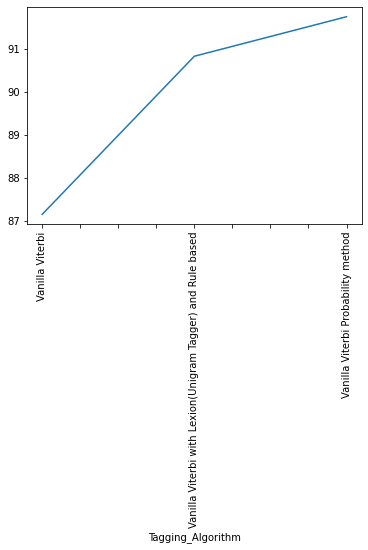

In [84]:
acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)
acccuracy_data_df.plot.line(rot = 90, legend = False)

##### INFERENCE:
    
- We can see an increase in accuracy for both the modified methods compared to the Vanilla Viterbi Method

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [85]:
incorrect_tagged_cases # incorrectly tagged word in Vanilla Viterbiz

[[('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('York-based', 'ADJ'), (('Loews', 'DET'), ('Loews', 'NOUN'))],
 [('Corp.', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('its', 'PRON'), (('Micronite', 'DET'), ('Micronite', 'NOUN'))],
 [('they', 'PRON'), (('test-drive', 'DET'), ('test-drive', 'VERB'))],
 [('an', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('Express', 'NOUN'), (('calculator', 'DET'), ('calculator', 'NOUN'))],
 [('*', 'X'), (('Filling', 'DET'), ('Filling', 'VERB'))],
 [('Filling', 'VERB'), (('out', 'ADP'), ('out', 'PRT'))],
 [('would', 'VERB'), (('tip', 'DET'), ('tip', 'VERB'))],
 [('worth', 'ADJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('broken', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('a', 'DET'), (('Sanford', 'DET'), ('Sanford', 'NOUN'))]]

In [86]:
rule_incorrect_tagged_cases #rule based incorrect tags

[[('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('Corp.', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('they', 'PRON'), (('test-drive', 'ADJ'), ('test-drive', 'VERB'))],
 [('an', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('*', 'X'), (('Filling', 'NOUN'), ('Filling', 'VERB'))],
 [('out', 'PRT'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('would', 'VERB'), (('tip', 'NOUN'), ('tip', 'VERB'))],
 [('worth', 'ADJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('broken', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

In [87]:
prob_incorrect_tagged_cases # probability based incorrect tags

[[('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('Corp.', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('its', 'PRON'), (('Micronite', 'VERB'), ('Micronite', 'NOUN'))],
 [('an', 'DET'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('out', 'PRT'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('would', 'VERB'), (('tip', 'X'), ('tip', 'VERB'))],
 [('worth', 'ADJ'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('broken', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

#### Inference:

We can see that there are lesser unknown or incorrectly tagged words in the modified methods than the original Viterbi Method

#### Evaluating using the Sample sentences given

In [88]:

sentence_test = open('Test_sentences.txt',mode='r').read() #read the sample text
words = word_tokenize(sentence_test) #tokennize

start = time.time()
tagged_seq = Viterbi(words)#original Model
end = time.time()
difference = end-start

print(tagged_seq) #tagged words
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'DET'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NO

In [89]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases # original 

[[('.', '.'), (('Android', 'DET'), ('Lorillard', 'NOUN'))],
 [('Lorillard', 'NOUN'), (('is', 'VERB'), ('Inc.', 'NOUN'))],
 [('Inc.', 'NOUN'), (('a', 'DET'), (',', '.'))],
 [(',', '.'), (('mobile', 'ADJ'), ('the', 'DET'))],
 [('the', 'DET'), (('operating', 'NOUN'), ('unit', 'NOUN'))],
 [('unit', 'NOUN'), (('system', 'NOUN'), ('of', 'ADP'))],
 [('of', 'ADP'), (('developed', 'VERB'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('by', 'ADP'), ('York-based', 'ADJ'))],
 [('York-based', 'ADJ'), (('Google', 'DET'), ('Loews', 'NOUN'))],
 [('Loews', 'NOUN'), (('.', '.'), ('Corp.', 'NOUN'))],
 [('Corp.', 'NOUN'), (('Android', 'DET'), ('that', 'DET'))],
 [('that', 'DET'), (('has', 'VERB'), ('*T*-2', 'X'))],
 [('*T*-2', 'X'), (('been', 'VERB'), ('makes', 'VERB'))],
 [('makes', 'VERB'), (('the', 'DET'), ('Kent', 'NOUN'))],
 [('Kent', 'NOUN'), (('best-selling', 'DET'), ('cigarettes', 'NOUN'))],
 [('cigarettes', 'NOUN'), (('OS', 'DET'), (',', '.'))],
 [(',', '.'), (('worldwide', 'DET'), ('stopped', 'VERB'))]

In [90]:

sentence_test = open('Test_sentences.txt',mode='r').read() #read
words = word_tokenize(sentence_test) #tokenize

start = time.time()
tagged_seq = modified_Viterbi_lexirule_based(words) #modified with lexion and rule based
end = time.time()
difference = end-start

print(tagged_seq) #tagged words
print(difference) #time
vannila_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
best-selling
VERB
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
ADJ
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'VERB'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter

In [91]:

sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_prob_based(words) #modified with probabilities
end = time.time() 
difference = end-start

print(tagged_seq) #tagged words
print(difference)# time
vannila_test_tagged_seq = tagged_seq

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('use

.

##### List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

- 'Twitter', 'Android', 'Google' which was tagged as Adjective 'ADJ' are properly tagged with 'NOUN' in both the modified algorithms.
- Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' in both modifications.
- Integers and float are properly tagged as 'NUM'in Lexion_Rule based tagging. example: years 2011,2013.
- Words like 'arriving' with -ing have been correctly mapped as VERB in Lexion_Rule Based tagging.
